In [1]:
import numpy as np
import matplotlib.pyplot as plt

from aeons.utils import *
from aeons.endpoint import *
from aeons.plotting import *
from aeons.toy_samples import gaussian_samples
figsettings()

In [2]:
from aeons.toy_samples import gaussian_samples
samples = gaussian_samples(500, 8, 0.01, seed=1)

In [72]:
samples = pickle_in('gauss/gauss_32.pkl')
model = EndModel(samples)
true_endpoint = model.true_endpoint()

In [75]:
iterations = make_iterations(true_endpoint, 10)
logLmaxs = np.zeros(len(iterations))
ds = np.zeros(len(iterations))
sigmas = np.zeros(len(iterations))
logLmaxs_std = np.zeros(len(iterations))
ds_std = np.zeros(len(iterations))
sigmas_std = np.zeros(len(iterations))
logXfs = np.zeros(len(iterations))
logXfs_std = np.zeros(len(iterations))

Nset = 25
for i, ndead in enumerate(iterations):
    logL, X_mean, nk, logZdead = model.data(ndead)
    theta_set = np.zeros((Nset, 3))
    logXf_set = np.zeros(Nset)
    for j in range(Nset):
        X = generate_Xs(nk)
        theta = theta_bandwidth_trunc(logL[ndead:], X[ndead:])
        theta_set[j] = theta
        logXf_set[j] = logXf_formula(theta, logZdead, X_mean[ndead])
    logLmaxs_set = reject_outliers(theta_set[:, 0])
    ds_set = reject_outliers(theta_set[:, 1])
    sigmas_set = reject_outliers(theta_set[:, 2])
    
    logLmaxs[i], logLmaxs_std[i] = np.mean(logLmaxs_set), np.std(logLmaxs_set)
    ds[i], ds_std[i] = np.mean(ds_set), np.std(ds_set)
    sigmas[i], sigmas_std[i] = np.mean(sigmas_set), np.std(sigmas_set)
    logXf_set = logXf_set[~np.isnan(logXf_set)]
    logXf_set = reject_outliers(logXf_set)
    logXfs[i], logXfs_std[i] = np.mean(logXf_set), np.std(logXf_set)
    # Print progress bar for iteration number
    print(f"Iteration {ndead} of {iterations[-1]}", end="\r")    

/home/zixiao/Documents/III/project/aeons/aeons/regress.py:24: RuntimeWarning: divide by zero encountered in scalar divide
  return 1/n * logsum + 1/(2*n*sigma_squared_analytic(d, X_i, logL_i)) * sum_X_2d
/home/zixiao/Documents/III/project/aeons/aeons/regress.py:42: RuntimeWarning: divide by zero encountered in divide
  (Xdata**(2/d)) / (2 * sigma_squared_analytic(d, Xdata, logLdata)) )
/home/zixiao/Documents/III/project/aeons/aeons/regress.py:41: RuntimeWarning: invalid value encountered in subtract
  return logLdata - (logLmax_analytic(d, Xdata, logLdata) - \
/home/zixiao/Documents/III/project/env/lib/python3.10/site-packages/numpy/linalg/linalg.py:2139: RuntimeWarning: invalid value encountered in det
  r = _umath_linalg.det(a, signature=signature)


In [79]:
write_to_txt('gauss/gauss_32_sigmas.txt', [iterations, sigmas, sigmas_std])

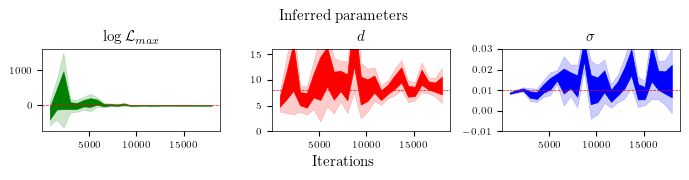

In [90]:
# 3 plots
iterations, logLmaxs, logLmaxs_std = read_from_txt('gauss/gauss_8_logLmaxs.txt')
_, ds, ds_std = read_from_txt('gauss/gauss_8_ds.txt')
_, sigmas, sigmas_std = read_from_txt('gauss/gauss_8_sigmas.txt')
fig, axs = plt.subplots(1, 3, figsize=(7, 2)) 
plot_std(iterations, logLmaxs, logLmaxs_std, true=0, ax=axs[0], color='green')
plot_std(iterations, ds, ds_std, true=8, ylim=(0, 2), ax=axs[1], color='red')
plot_std(iterations, abs(sigmas), sigmas_std, true=0.01, ylim=(-1, 3), ax=axs[2], color='blue')
axs[0].set_title("$\\log \\mathcal{L}_{max}$")
axs[1].set_title("$d$")
axs[2].set_title("$\\sigma$")
fig.suptitle('Inferred parameters', y=.9)
fig.supxlabel('Iterations', y=.1)
fig.tight_layout()